# Imports

In [16]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics

# Gather/Clean Data

In [13]:
# Using Stage 2 because it contains 2021 data

df_season_results = pd.read_csv("Data/2021/MDataFiles_Stage2/MRegularSeasonDetailedResults.csv")
df_season_compact = pd.read_csv("Data/2021/MDataFiles_Stage2/MRegularSeasonCompactResults.csv")
df_teams = pd.read_csv("Data/2021/MDataFiles_Stage2/MTeams.csv")
df_teamSpellings = pd.read_csv("Data/2021/MDataFiles_Stage2/MTeamSpellings.csv", sep='\,', engine='python')
df_kenPom = pd.read_csv("Data/2021/kenPom.csv")

df_kenPom.head()

,Rk,TeamName_Clean,AdjEM,AdjO,AdjD,AdjT,Luck,SOS_AdjEM,SOS_OppO,SOS_OppD,NCSOS_AdjEM
0,1,Gonzaga,36.59,126.0,89.4,74.7,0.018,7.93,105.9,98.0,6.34
1,2,Illinois,30.70,118.8,88.1,70.6,0.026,18.27,112.4,94.1,9.99
2,3,Michigan,30.50,119.3,88.8,66.8,0.026,16.75,111.3,94.6,2.73
3,4,Baylor,29.93,123.0,93.0,68.7,0.047,9.64,106.3,96.7,-3.71
4,5,Houston,29.68,119.6,89.9,65.0,-0.011,6.82,103.9,97.1,1.99


### Merge KenPom Data with TeamIDs

In [6]:
df_kenPom["TeamName_Clean"] = df_kenPom["TeamName_Clean"].str.lower()
df_kenPom["TeamName_Clean"] = df_kenPom['TeamName_Clean'].str.strip()

kp_df = pd.merge(df_kenPom, df_teamSpellings, left_on=['TeamName_Clean'], right_on = ['TeamNameSpelling'], how='left')
kp_df = kp_df.drop(['TeamNameSpelling'], axis=1)

#Check if any team is blank
kp_df.loc[kp_df.TeamID.isna()]

,Rk,TeamName_Clean,AdjEM,AdjO,AdjD,AdjT,Luck,SOS_AdjEM,SOS_OppO,SOS_OppD,NCSOS_AdjEM,TeamID


# Data Exploration
### 2021 Season Data

In [22]:
df_2021 = df_season_results.loc[df_season_results.Season == 2021].reset_index(drop=True)
df_2021.shape

(3855, 34)

In [23]:
df_2021.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
count,3855.0,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000,3855.000000
mean,2021.0,79.274189,1290.841245,76.808301,1288.496757,64.807004,0.067445,27.302724,57.679377,7.933852,21.255253,14.269001,19.655253,8.578470,25.695460,14.663554,12.105577,6.847471,3.496498,4.919066,23.284565,57.800000,6.660960,21.918807,11.576913,16.747082,8.111803,21.691829,11.465110,13.310506,5.909468,2.847211,5.300389
std,0.0,31.420038,105.990924,10.516196,104.528980,10.284112,0.303271,4.548411,7.018578,3.157521,5.903893,5.861798,7.517784,3.692445,4.812264,4.452967,3.748864,3.002953,2.223833,7.763078,4.185217,7.070826,2.813521,5.970599,5.169894,6.780922,3.562432,4.394939,3.735378,4.097771,2.654338,1.964594,8.361174
min,2021.0,23.000000,1101.000000,45.000000,1101.000000,30.000000,0.000000,12.000000,34.000000,0.000000,6.000000,1.000000,2.000000,0.000000,10.000000,2.000000,2.000000,0.000000,0.000000,0.000000,10.000000,33.000000,0.000000,5.000000,0.000000,0.000000,0.000000,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2021.0,51.000000,1202.000000,69.000000,1199.000000,58.000000,0.000000,24.000000,53.000000,6.000000,17.000000,10.000000,14.000000,6.000000,22.000000,12.000000,9.000000,5.000000,2.000000,0.000000,20.000000,53.000000,5.000000,18.000000,8.000000,12.000000,6.000000,19.000000,9.000000,10.000000,4.000000,1.000000,0.000000
50%,2021.0,82.000000,1288.000000,76.000000,1291.000000,65.000000,0.000000,27.000000,57.000000,8.000000,21.000000,14.000000,19.000000,8.000000,26.000000,14.000000,12.000000,7.000000,3.000000,0.000000,23.000000,58.000000,7.000000,22.000000,11.000000,16.000000,8.000000,22.000000,11.000000,13.000000,6.000000,3.000000,0.000000
75%,2021.0,107.000000,1385.000000,83.000000,1379.000000,71.000000,0.000000,30.000000,62.000000,10.000000,25.000000,18.000000,25.000000,11.000000,29.000000,17.000000,15.000000,9.000000,5.000000,13.000000,26.000000,62.000000,8.000000,26.000000,15.000000,21.000000,10.000000,25.000000,14.000000,16.000000,8.000000,4.000000,14.000000
max,2021.0,132.000000,1471.000000,142.000000,1471.000000,120.000000,4.000000,48.000000,95.000000,23.000000,43.000000,40.000000,51.000000,24.000000,46.000000,34.000000,30.000000,20.000000,14.000000,30.000000,39.000000,98.000000,20.000000,43.000000,41.000000,59.000000,29.000000,40.000000,26.000000,35.000000,18.000000,13.000000,33.000000


#### Merge 2021 w/ 2021 KenPom Data

In [24]:
#Winner Data
df_2021 = pd.merge(df_2021, kp_df, left_on =['WTeamID'], right_on=['TeamID'], how='left', validate="m:1")
df_2021

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Rk,TeamName_Clean,AdjEM,AdjO,AdjD,AdjT,Luck,SOS_AdjEM,SOS_OppO,SOS_OppD,NCSOS_AdjEM,TeamID
0,2021,23,1101,70,1190,47,N,0,20,49,13,23,17,27,6,24,14,15,8,3,0,15,51,3,21,14,17,11,27,5,22,6,2,0,85,abilene christian,10.39,103.3,92.9,69.9,-0.027,-7.74,97.8,105.6,4.68,1101
1,2021,23,1104,81,1240,57,H,0,30,77,7,31,14,20,19,31,11,10,8,3,0,19,69,9,32,10,17,18,28,10,20,5,2,0,7,alabama,24.87,111.7,86.9,73.8,0.031,14.25,109.7,95.5,9.15,1104
2,2021,23,1111,81,1354,61,A,0,32,62,7,27,10,13,13,41,15,23,6,3,13,24,80,7,32,6,11,12,18,12,9,13,0,14,208,appalachian st.,-4.39,98.4,102.8,65.7,0.039,-2.76,100.4,103.1,5.61,1111
3,2021,23,1113,94,1348,88,N,0,27,61,6,20,34,46,13,22,9,12,7,4,0,29,56,9,18,21,35,7,26,14,16,8,2,0,110,arizona st.,6.82,106.8,100.0,72.8,0.026,12.76,109.1,96.4,8.72,1113
4,2021,23,1114,71,1341,66,N,0,22,51,4,17,23,29,16,16,7,19,13,4,0,27,55,8,21,4,4,7,15,14,24,12,1,0,234,little rock,-6.72,98.3,105.0,67.2,-0.040,-2.90,99.6,102.5,3.86,1114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3850,2021,132,1104,80,1261,79,N,0,33,76,12,36,2,5,16,31,16,9,4,8,15,30,74,10,27,9,13,15,26,10,5,6,5,13,7,alabama,24.87,111.7,86.9,73.8,0.031,14.25,109.7,95.5,9.15,1104
3851,2021,132,1159,85,1259,72,H,0,31,59,14,23,9,14,6,20,18,8,9,1,15,29,62,5,22,9,16,12,19,12,12,2,1,13,86,colgate,9.83,110.4,100.6,72.5,0.048,-5.43,99.7,105.1,-99.00,1159
3852,2021,132,1222,91,1153,54,N,0,37,66,11,23,6,7,10,26,24,6,8,4,16,18,65,8,33,10,15,14,17,11,10,2,5,12,5,houston,29.68,119.6,89.9,65.0,-0.011,6.82,103.9,97.1,1.99,1222
3853,2021,132,1228,91,1326,88,N,1,29,64,9,21,24,32,13,27,15,10,5,2,23,29,65,8,25,22,30,8,27,11,8,7,4,26,2,illinois,30.70,118.8,88.1,70.6,0.026,18.27,112.4,94.1,9.99,1228


In [36]:
#Winner Clean
df_2021['Winning_Team'] = df_2021['TeamName_Clean']

df_2021 = df_2021[['WTeamID', 'Winning_Team', 'WScore', 'AdjEM', 'AdjO', 'AdjD', 'AdjT', 'Luck',
         'SOS_AdjEM','SOS_OppO', 'SOS_OppD', 'NCSOS_AdjEM', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 
         'WFTM', 'WFTA', 'WOR', 'WDR','WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LTeamID', 
         'LScore', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA','LOR', 'LDR', 'LAst', 'LTO', 
         'LStl', 'LBlk', 'LPF']]


In [44]:
#Loser Data
df_2021 = pd.merge(df_2021, kp_df, left_on =['LTeamID'], right_on=['TeamID'], how='left', validate="m:1")
df_2021

,WTeamID,Winning_Team,WScore,AdjEM_x,AdjO_x,AdjD_x,AdjT_x,Luck_x,SOS_AdjEM_x,SOS_OppO_x,SOS_OppD_x,NCSOS_AdjEM_x,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LTeamID,Losing_Team,LScore,AdjEM_y,AdjO_y,AdjD_y,AdjT_y,Luck_y,SOS_AdjEM_y,SOS_OppO_y,SOS_OppD_y,NCSOS_AdjEM_y,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Rk,TeamName_Clean,AdjEM,AdjO,AdjD,AdjT,Luck,SOS_AdjEM,SOS_OppO,SOS_OppD,NCSOS_AdjEM,TeamID
0,1101,abilene christian,70,10.39,103.3,92.9,69.9,-0.027,-7.74,97.8,105.6,4.68,20,49,13,23,17,27,6,24,14,15,8,3,0,1190,east tennessee st.,47,4.29,103.1,98.9,65.6,-0.063,3.91,104.9,101.0,4.78,15,51,3,21,14,17,11,27,5,22,6,2,0,126,east tennessee st.,4.29,103.1,98.9,65.6,-0.063,3.91,104.9,101.0,4.78,1190
1,1104,alabama,81,24.87,111.7,86.9,73.8,0.031,14.25,109.7,95.5,9.15,30,77,7,31,14,20,19,31,11,10,8,3,0,1240,jacksonville st.,57,0.70,105.0,104.3,66.1,0.017,-2.68,101.0,103.7,4.72,19,69,9,32,10,17,18,28,10,20,5,2,0,160,jacksonville st.,0.70,105.0,104.3,66.1,0.017,-2.68,101.0,103.7,4.72,1240
2,1111,appalachian st.,81,-4.39,98.4,102.8,65.7,0.039,-2.76,100.4,103.1,5.61,32,62,7,27,10,13,13,41,15,23,6,3,13,1354,south carolina st.,61,-25.02,87.1,112.1,71.9,-0.109,-4.54,98.2,102.7,2.12,24,80,7,32,6,11,12,18,12,9,13,0,14,353,south carolina st.,-25.02,87.1,112.1,71.9,-0.109,-4.54,98.2,102.7,2.12,1354
3,1113,arizona st.,94,6.82,106.8,100.0,72.8,0.026,12.76,109.1,96.4,8.72,27,61,6,20,34,46,13,22,9,12,7,4,0,1348,rhode island,88,7.77,104.9,97.1,69.2,-0.109,9.61,106.6,97.0,10.83,29,56,9,18,21,35,7,26,14,16,8,2,0,105,rhode island,7.77,104.9,97.1,69.2,-0.109,9.61,106.6,97.0,10.83,1348
4,1114,little rock,71,-6.72,98.3,105.0,67.2,-0.040,-2.90,99.6,102.5,3.86,22,51,4,17,23,29,16,16,7,19,13,4,0,1341,prairie view a&m,66,-6.84,94.4,101.2,69.4,0.111,-14.40,92.9,107.3,6.58,27,55,8,21,4,4,7,15,14,24,12,1,0,240,prairie view a&m,-6.84,94.4,101.2,69.4,0.111,-14.40,92.9,107.3,6.58,1341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3850,1104,alabama,80,24.87,111.7,86.9,73.8,0.031,14.25,109.7,95.5,9.15,33,76,12,36,2,5,16,31,16,9,4,8,15,1261,lsu,79,19.55,119.8,100.3,70.7,0.002,13.63,107.9,94.2,1.17,30,74,10,27,9,13,15,26,10,5,6,5,13,27,lsu,19.55,119.8,100.3,70.7,0.002,13.63,107.9,94.2,1.17,1261
3851,1159,colgate,85,9.83,110.4,100.6,72.5,0.048,-5.43,99.7,105.1,-99.00,31,59,14,23,9,14,6,20,18,8,9,1,15,1259,loyola md,72,-4.57,96.9,101.5,68.6,-0.190,-4.15,101.9,106.1,-99.00,29,62,5,22,9,16,12,19,12,12,2,1,13,210,loyola md,-4.57,96.9,101.5,68.6,-0.190,-4.15,101.9,106.1,-99.00,1259
3852,1222,houston,91,29.68,119.6,89.9,65.0,-0.011,6.82,103.9,97.1,1.99,37,66,11,23,6,7,10,26,24,6,8,4,16,1153,cincinnati,54,5.95,103.4,97.5,70.9,0.115,10.68,107.0,96.4,9.36,18,65,8,33,10,15,14,17,11,10,2,5,12,117,cincinnati,5.95,103.4,97.5,70.9,0.115,10.68,107.0,96.4,9.36,1153
3853,1228,illinois,91,30.70,118.8,88.1,70.6,0.026,18.27,112.4,94.1,9.99,29,64,9,21,24,32,13,27,15,10,5,2,23,1326,ohio st.,88,24.19,120.8,96.6,67.0,-0.012,18.19,111.7,93.5,2.84,29,65,8,25,22,30,8,27,11,8,7,4,26,9,ohio st.,24.19,120.8,96.6,67.0,-0.012,18.19,111.7,93.5,2.84,1326


In [45]:
df_2021['Losing_Team'] = df_2021['TeamName_Clean']

df_2021 = df_2021[['WTeamID', 'Winning_Team', 'WScore', 'AdjEM_x', 'AdjO_x', 'AdjD_x','AdjT_x', 'Luck_x', 
         'SOS_AdjEM_x', 'SOS_OppO_x', 'SOS_OppD_x','NCSOS_AdjEM_x', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3',
         'WFTM', 'WFTA','WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 
         'LTeamID', 'Losing_Team', 'LScore','AdjEM_y','AdjO_y', 'AdjD_y', 'AdjT_y', 'Luck_y', 
         'SOS_AdjEM_y', 'SOS_OppO_y','SOS_OppD_y', 'NCSOS_AdjEM_y', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 
         'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst','LTO', 'LStl', 'LBlk', 'LPF']]

#Clean Season Df
df_2021.head()

,WTeamID,Winning_Team,WScore,AdjEM_x,AdjO_x,AdjD_x,AdjT_x,Luck_x,SOS_AdjEM_x,SOS_OppO_x,SOS_OppD_x,NCSOS_AdjEM_x,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LTeamID,Losing_Team,LScore,AdjEM_y,AdjO_y,AdjD_y,AdjT_y,Luck_y,SOS_AdjEM_y,SOS_OppO_y,SOS_OppD_y,NCSOS_AdjEM_y,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,1101,abilene christian,70,10.39,103.3,92.9,69.9,-0.027,-7.74,97.8,105.6,4.68,20,49,13,23,17,27,6,24,14,15,8,3,0,1190,east tennessee st.,47,4.29,103.1,98.9,65.6,-0.063,3.91,104.9,101.0,4.78,15,51,3,21,14,17,11,27,5,22,6,2,0
1,1104,alabama,81,24.87,111.7,86.9,73.8,0.031,14.25,109.7,95.5,9.15,30,77,7,31,14,20,19,31,11,10,8,3,0,1240,jacksonville st.,57,0.70,105.0,104.3,66.1,0.017,-2.68,101.0,103.7,4.72,19,69,9,32,10,17,18,28,10,20,5,2,0
2,1111,appalachian st.,81,-4.39,98.4,102.8,65.7,0.039,-2.76,100.4,103.1,5.61,32,62,7,27,10,13,13,41,15,23,6,3,13,1354,south carolina st.,61,-25.02,87.1,112.1,71.9,-0.109,-4.54,98.2,102.7,2.12,24,80,7,32,6,11,12,18,12,9,13,0,14
3,1113,arizona st.,94,6.82,106.8,100.0,72.8,0.026,12.76,109.1,96.4,8.72,27,61,6,20,34,46,13,22,9,12,7,4,0,1348,rhode island,88,7.77,104.9,97.1,69.2,-0.109,9.61,106.6,97.0,10.83,29,56,9,18,21,35,7,26,14,16,8,2,0
4,1114,little rock,71,-6.72,98.3,105.0,67.2,-0.040,-2.90,99.6,102.5,3.86,22,51,4,17,23,29,16,16,7,19,13,4,0,1341,prairie view a&m,66,-6.84,94.4,101.2,69.4,0.111,-14.40,92.9,107.3,6.58,27,55,8,21,4,4,7,15,14,24,12,1,0


# Correlations

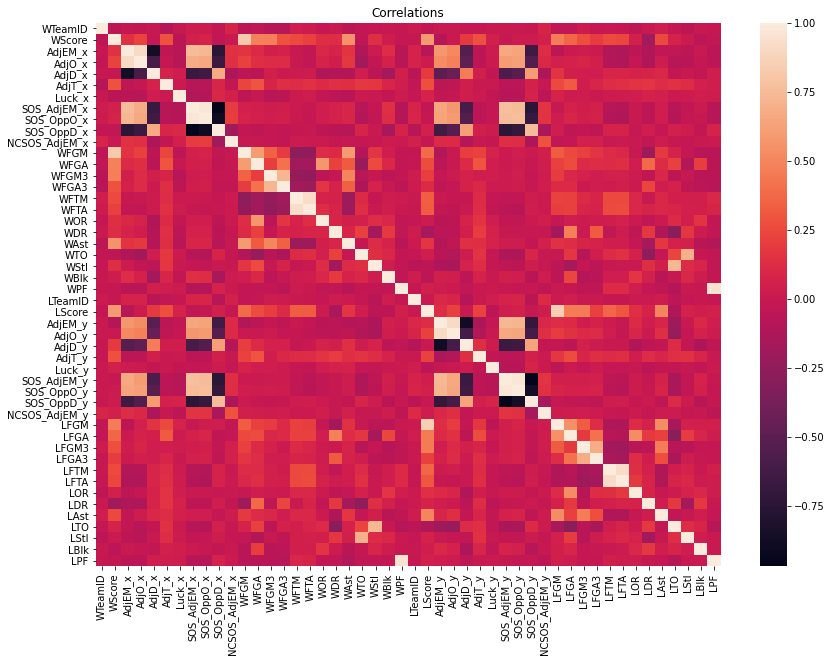

In [48]:
plt.figure(figsize=(14,10))
sns.heatmap(df_2021.corr())

plt.title('Correlations')
plt.show()

In [99]:
df_2021.corr()['WScore']

WTeamID         -0.053053
WScore           1.000000
AdjEM_x          0.148183
AdjO_x           0.226362
AdjD_x          -0.020753
AdjT_x           0.292313
Luck_x          -0.063534
SOS_AdjEM_x      0.059896
SOS_OppO_x       0.076975
SOS_OppD_x      -0.036977
NCSOS_AdjEM_x    0.001858
WFGM             0.823706
WFGA             0.477918
WFGM3            0.475502
WFGA3            0.286661
WFTM             0.259593
WFTA             0.223141
WOR              0.138237
WDR              0.124432
WAst             0.554386
WTO             -0.039048
WStl             0.133601
WBlk             0.029689
WPF             -0.017919
LTeamID         -0.014362
LScore           0.585473
AdjEM_y         -0.094915
AdjO_y           0.003439
AdjD_y           0.187021
AdjT_y           0.278638
Luck_y           0.060832
SOS_AdjEM_y     -0.000961
SOS_OppO_y       0.016186
SOS_OppD_y       0.021204
NCSOS_AdjEM_y    0.060399
LFGM             0.466680
LFGA             0.366695
LFGM3            0.273475
LFGA3       

In [211]:
regress_df = df_2021.drop(['Winning_Team', 'Losing_Team', 'WTeamID', 'LTeamID', 'LScore', 'WFGM', 'WFGM3', 
                           'WFTM', 'LFGM', 'LFGM3', 'LFTM', ], axis=1)
regress_df.head()

,WScore,AdjEM_x,AdjO_x,AdjD_x,AdjT_x,Luck_x,SOS_AdjEM_x,SOS_OppO_x,SOS_OppD_x,NCSOS_AdjEM_x,WFGA,WFGA3,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,AdjEM_y,AdjO_y,AdjD_y,AdjT_y,Luck_y,SOS_AdjEM_y,SOS_OppO_y,SOS_OppD_y,NCSOS_AdjEM_y,LFGA,LFGA3,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,70,10.39,103.3,92.9,69.9,-0.027,-7.74,97.8,105.6,4.68,49,23,27,6,24,14,15,8,3,0,4.29,103.1,98.9,65.6,-0.063,3.91,104.9,101.0,4.78,51,21,17,11,27,5,22,6,2,0
1,81,24.87,111.7,86.9,73.8,0.031,14.25,109.7,95.5,9.15,77,31,20,19,31,11,10,8,3,0,0.70,105.0,104.3,66.1,0.017,-2.68,101.0,103.7,4.72,69,32,17,18,28,10,20,5,2,0
2,81,-4.39,98.4,102.8,65.7,0.039,-2.76,100.4,103.1,5.61,62,27,13,13,41,15,23,6,3,13,-25.02,87.1,112.1,71.9,-0.109,-4.54,98.2,102.7,2.12,80,32,11,12,18,12,9,13,0,14
3,94,6.82,106.8,100.0,72.8,0.026,12.76,109.1,96.4,8.72,61,20,46,13,22,9,12,7,4,0,7.77,104.9,97.1,69.2,-0.109,9.61,106.6,97.0,10.83,56,18,35,7,26,14,16,8,2,0
4,71,-6.72,98.3,105.0,67.2,-0.040,-2.90,99.6,102.5,3.86,51,17,29,16,16,7,19,13,4,0,-6.84,94.4,101.2,69.4,0.111,-14.40,92.9,107.3,6.58,55,21,4,7,15,14,24,12,1,0


# Model Building

In [212]:
def in_sample_results(regression, y_train, in_preds):
    ev = metrics.explained_variance_score(y_train, in_preds)
    mae =metrics.mean_absolute_error(y_train, in_preds) 
    mse=metrics.mean_squared_error(y_train, in_preds) 
    r2=metrics.r2_score(y_train, in_preds)
    
    print(f'{regression}')
    print('----------------------------------------------')
    print('IN SAMPLE RESULTS')
    print('Explained Variance: ', ev)
    print('r2: ', r2)
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE ', np.sqrt(mse))
    print('----------------------------------------------')

In [213]:
def out_sample_results(y_test, out_preds):
    ev = metrics.explained_variance_score(y_test, out_preds)
    mae =metrics.mean_absolute_error(y_test, out_preds) 
    mse=metrics.mean_squared_error(y_test, out_preds) 
    r2=metrics.r2_score(y_test, out_preds)
    
    print('----------------------------------------------')
    print('OUT SAMPLE RESULTS')
    print('Explained Variance: ', ev)
    print('r2: ', r2)
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE ', np.sqrt(mse))
    print('----------------------------------------------')

In [214]:
# get pandas columns for prediction
target = regress_df["WScore"]
features = regress_df.drop(["WScore"], axis=1)

# convert to lists/arrays (MUST HAPPEN)
X = np.array(features)
y = np.array(target)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Linear Regressions

Linear Regression
----------------------------------------------
IN SAMPLE RESULTS
Explained Variance:  0.8506812260995547
r2:  0.8506812260995547
MAE:  3.200989553626568
MSE:  16.508385157986904
RMSE  4.063051212818626
----------------------------------------------
----------------------------------------------
OUT SAMPLE RESULTS
Explained Variance:  0.863565048093116
r2:  0.86299281118505
MAE:  3.094432721471126
MSE:  15.13660223401896
RMSE  3.8905786502805673
----------------------------------------------


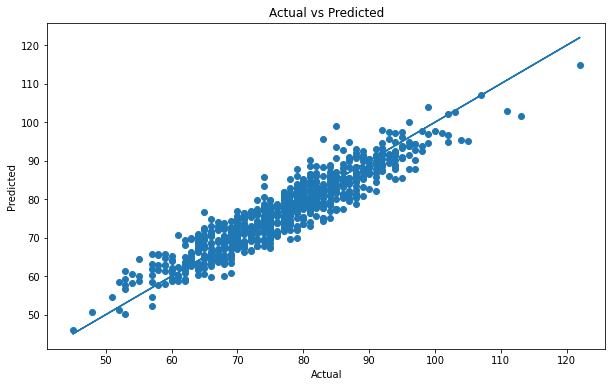

In [215]:
# train the model
reg = LinearRegression()
reg.fit(X_train, y_train)

#get predictions
in_sample_preds = reg.predict(X_train)
out_sample_preds = reg.predict(X_test)

#metric report
in_sample_results('Linear Regression', y_train, in_sample_preds)
out_sample_results(y_test, out_sample_preds)

# predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)
plt.plot(y_test, y_test)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.show()

Ridge Regression
----------------------------------------------
IN SAMPLE RESULTS
Explained Variance:  0.8506608688736759
r2:  0.8506608688736758
MAE:  3.2020091249715716
MSE:  16.510635812186496
RMSE  4.063328169393471
----------------------------------------------
----------------------------------------------
OUT SAMPLE RESULTS
Explained Variance:  0.8636581794825872
r2:  0.8630692762985797
MAE:  3.092956117573563
MSE:  15.12815434147925
RMSE  3.8894928128843804
----------------------------------------------


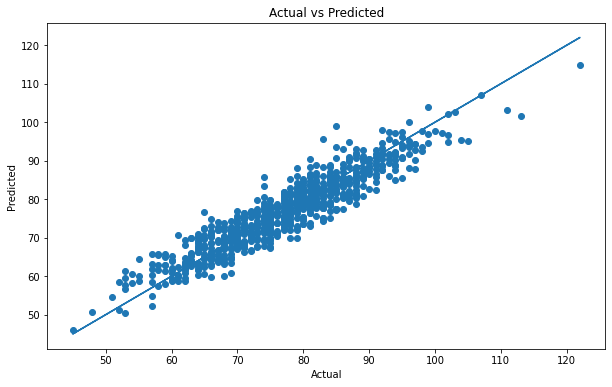

In [216]:
# train the model
ridge = Ridge()
ridge.fit(X_train, y_train)

#get predictions
in_sample_preds = ridge.predict(X_train)
out_sample_preds = ridge.predict(X_test)

#metric report
in_sample_results('Ridge Regression', y_train, in_sample_preds)
out_sample_results(y_test, out_sample_preds)

# predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)
plt.plot(y_test, y_test)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.show()

Lasso Regression
----------------------------------------------
IN SAMPLE RESULTS
Explained Variance:  0.8337148477512508
r2:  0.8337148477512508
MAE:  3.38968583171368
MSE:  18.38415403281487
RMSE  4.287674664992071
----------------------------------------------
----------------------------------------------
OUT SAMPLE RESULTS
Explained Variance:  0.8428523599344933
r2:  0.8422987549623865
MAE:  3.3350214336751756
MSE:  17.422888817666486
RMSE  4.1740734082747615
----------------------------------------------


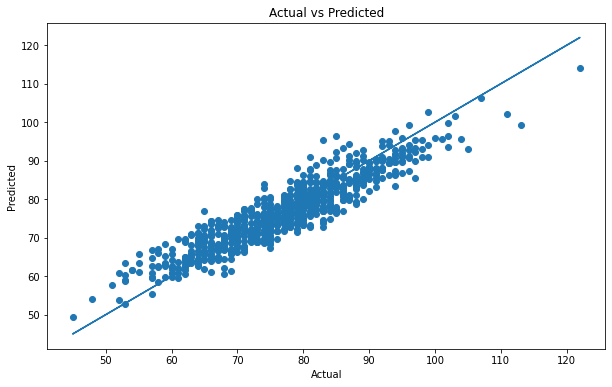

In [217]:
# train the model
lasso = Lasso()
lasso.fit(X_train, y_train)

#get predictions
in_sample_preds = lasso.predict(X_train)
out_sample_preds = lasso.predict(X_test)

#metric report
in_sample_results('Lasso Regression', y_train, in_sample_preds)
out_sample_results(y_test, out_sample_preds)

# predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)
plt.plot(y_test, y_test)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.show()

Elastic Net Regression
----------------------------------------------
IN SAMPLE RESULTS
Explained Variance:  0.840924022174166
r2:  0.8409240221741658
MAE:  3.3120616653089328
MSE:  17.58712211957442
RMSE  4.193700289669544
----------------------------------------------
----------------------------------------------
OUT SAMPLE RESULTS
Explained Variance:  0.8504415160833971
r2:  0.8498507379354537
MAE:  3.236818325920953
MSE:  16.588543092233063
RMSE  4.072903521105436
----------------------------------------------


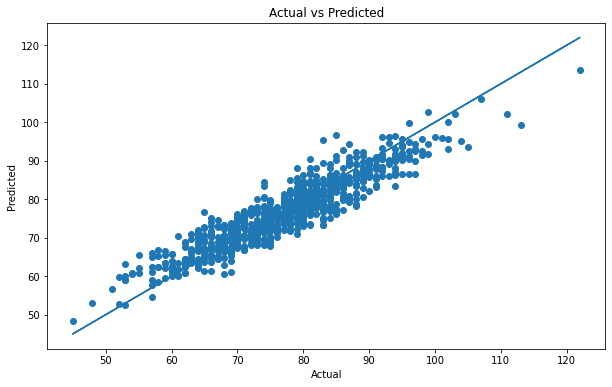

In [218]:
# train the model
en = ElasticNet()
en.fit(X_train, y_train)

#get predictions
in_sample_preds = en.predict(X_train)
out_sample_preds = en.predict(X_test)

#metric report
in_sample_results('Elastic Net Regression', y_train, in_sample_preds)
out_sample_results(y_test, out_sample_preds)

# predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)
plt.plot(y_test, y_test)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.show()

## Tree Based Models

Decision Tree Regression
----------------------------------------------
IN SAMPLE RESULTS
Explained Variance:  1.0
r2:  1.0
MAE:  0.0
MSE:  0.0
RMSE  0.0
----------------------------------------------
----------------------------------------------
OUT SAMPLE RESULTS
Explained Variance:  0.258272300855513
r2:  0.25712914004846665
MAE:  7.159533073929961
MSE:  82.07263294422827
RMSE  9.059394733878653
----------------------------------------------


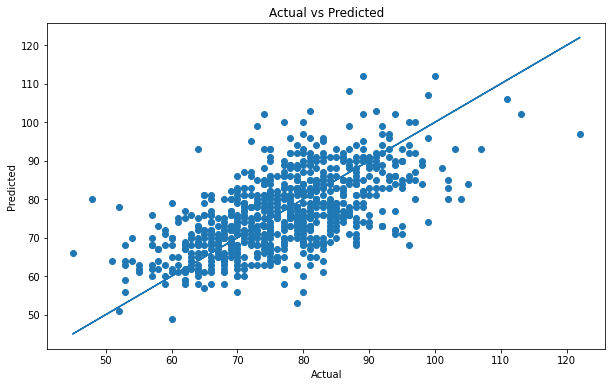

In [219]:
# train the model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

#get predictions
in_sample_preds = dt.predict(X_train)
out_sample_preds = dt.predict(X_test)

#metric report
in_sample_results('Decision Tree Regression', y_train, in_sample_preds)
out_sample_results(y_test, out_sample_preds)

# predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)
plt.plot(y_test, y_test)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.show()

Random Forest Regression
----------------------------------------------
IN SAMPLE RESULTS
Explained Variance:  0.9493443154303587
r2:  0.9493433861237387
MAE:  1.8289883268482487
MSE:  5.600493968871596
RMSE  2.3665362809117454
----------------------------------------------
----------------------------------------------
OUT SAMPLE RESULTS
Explained Variance:  0.663319604836309
r2:  0.6626560769664731
MAE:  4.860557717250324
MSE:  37.26987483787289
RMSE  6.104905800900854
----------------------------------------------


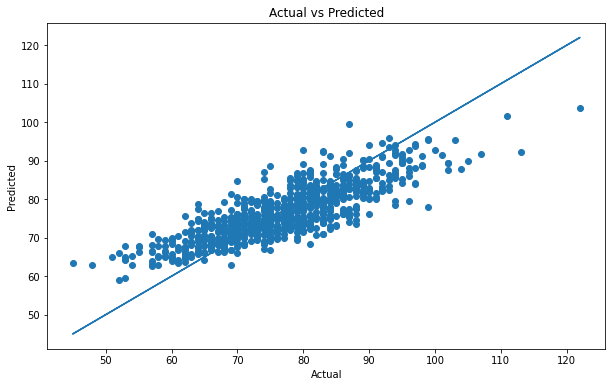

In [220]:
# train the model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

#get predictions
in_sample_preds = rf.predict(X_train)
out_sample_preds = rf.predict(X_test)

#metric report
in_sample_results('Random Forest Regression', y_train, in_sample_preds)
out_sample_results(y_test, out_sample_preds)

# predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)
plt.plot(y_test, y_test)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.show()

Ada Boost Regression
----------------------------------------------
IN SAMPLE RESULTS
Explained Variance:  0.6515173559856079
r2:  0.6495375389428863
MAE:  5.014046536324504
MSE:  38.74642912889311
RMSE  6.224662973116947
----------------------------------------------
----------------------------------------------
OUT SAMPLE RESULTS
Explained Variance:  0.6222775701351921
r2:  0.6222005612223762
MAE:  5.106031099063298
MSE:  41.73941439479041
RMSE  6.460604801006668
----------------------------------------------


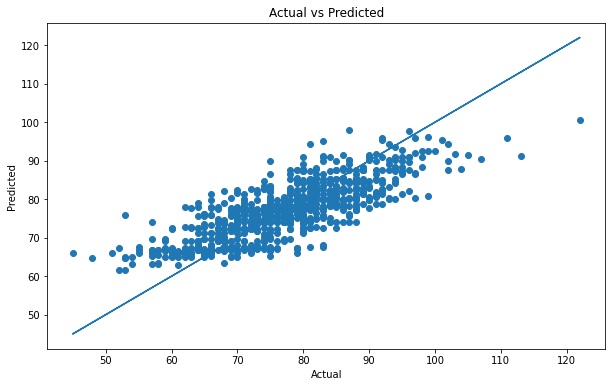

In [221]:
# train the model
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)

#get predictions
in_sample_preds = ada.predict(X_train)
out_sample_preds = ada.predict(X_test)

#metric report
in_sample_results('Ada Boost Regression', y_train, in_sample_preds)
out_sample_results(y_test, out_sample_preds)

# predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)
plt.plot(y_test, y_test)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.show()

Gradient Boosting Regression
----------------------------------------------
IN SAMPLE RESULTS
Explained Variance:  0.8297353795898892
r2:  0.8297353795898892
MAE:  3.4435215334885094
MSE:  18.82411607787897
RMSE  4.3386767657753635
----------------------------------------------
----------------------------------------------
OUT SAMPLE RESULTS
Explained Variance:  0.7541377286695298
r2:  0.7532904304633244
MAE:  4.194144295782202
MSE:  27.2565597010134
RMSE  5.220781522053322
----------------------------------------------


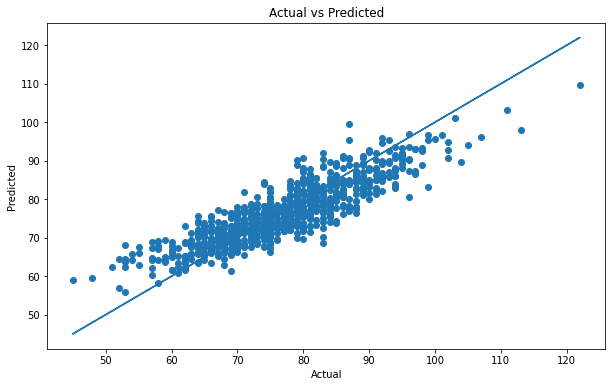

In [222]:
# train the model
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

#get predictions
in_sample_preds = gb.predict(X_train)
out_sample_preds = gb.predict(X_test)

#metric report
in_sample_results('Gradient Boosting Regression', y_train, in_sample_preds)
out_sample_results(y_test, out_sample_preds)

# predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)
plt.plot(y_test, y_test)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.show()

XTREME Gradient Boosting Regression
----------------------------------------------
IN SAMPLE RESULTS
Explained Variance:  0.9923780984440963
r2:  0.9923780976258741
MAE:  0.6630746072059166
MSE:  0.84266229049359
RMSE  0.9179663885424073
----------------------------------------------
----------------------------------------------
OUT SAMPLE RESULTS
Explained Variance:  0.7362101747815673
r2:  0.7354927538449865
MAE:  4.231525698215272
MSE:  29.222853250947818
RMSE  5.405816612774412
----------------------------------------------


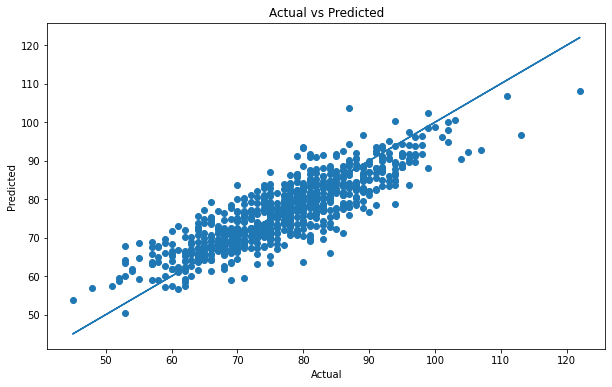

In [223]:
# train the model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

#get predictions
in_sample_preds = xgb.predict(X_train)
out_sample_preds = xgb.predict(X_test)

#metric report
in_sample_results('XTREME Gradient Boosting Regression', y_train, in_sample_preds)
out_sample_results(y_test, out_sample_preds)

# predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)
plt.plot(y_test, y_test)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.show()

KNN Regression
----------------------------------------------
IN SAMPLE RESULTS
Explained Variance:  0.6255363365548656
r2:  0.6225911845785479
MAE:  5.121206225680934
MSE:  41.72556420233464
RMSE  6.459532816104787
----------------------------------------------
----------------------------------------------
OUT SAMPLE RESULTS
Explained Variance:  0.4545973674533548
r2:  0.4480487589847131
MAE:  6.193774319066149
MSE:  60.979766536964995
RMSE  7.8089542537375
----------------------------------------------


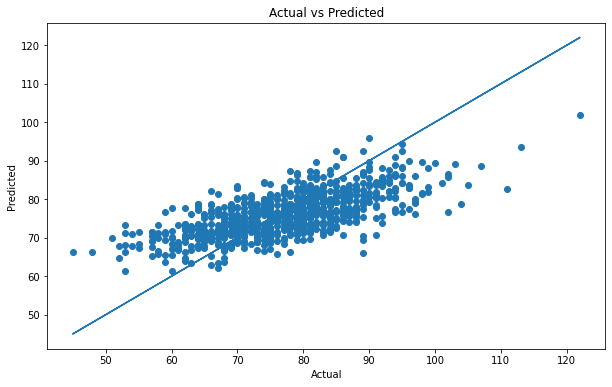

In [224]:
# train the model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

#get predictions
in_sample_preds = knn.predict(X_train)
out_sample_preds = knn.predict(X_test)

#metric report
in_sample_results('KNN Regression', y_train, in_sample_preds)
out_sample_results(y_test, out_sample_preds)

# predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)
plt.plot(y_test, y_test)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.show()

# GRADIENT BOOST MODEL

Gradient Boost Regression
----------------------------------------------
IN SAMPLE RESULTS
Explained Variance:  0.8144213562082021
r2:  0.8143861213410493
MAE:  3.5948696029713605
MSE:  20.521785047085096
RMSE  4.530097686262968
----------------------------------------------


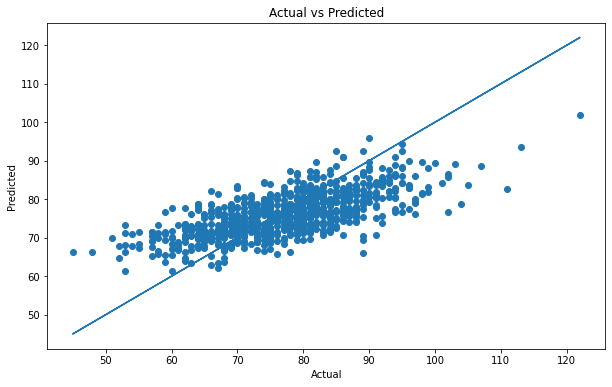

In [225]:
# train the model
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

#get predictions
in_sample_preds = gb.predict(X)

#metric report
in_sample_results('Gradient Boost Regression', y, in_sample_preds)

# predicted vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)
plt.plot(y_test, y_test)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.show()

# Testing

In [226]:
avg_df = df_2021.groupby("Winning_Team").mean()
avg_df['WTeamID'] = avg_df['WTeamID'].astype(int)
avg_df

,WTeamID,WScore,AdjEM_x,AdjO_x,AdjD_x,AdjT_x,Luck_x,SOS_AdjEM_x,SOS_OppO_x,SOS_OppD_x,NCSOS_AdjEM_x,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LTeamID,LScore,AdjEM_y,AdjO_y,AdjD_y,AdjT_y,Luck_y,SOS_AdjEM_y,SOS_OppO_y,SOS_OppD_y,NCSOS_AdjEM_y,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Winning_Team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
abilene christian,1101,78.947368,10.39,103.3,92.9,69.9,-0.027,-7.74,97.8,105.6,4.68,27.842105,59.421053,8.473684,21.789474,14.789474,21.105263,10.157895,23.421053,18.684211,13.421053,9.947368,3.052632,4.578947,1287.000000,59.789474,-11.174737,95.989474,107.168421,68.868421,-0.007053,-3.803158,99.926316,103.726316,6.218421,20.578947,51.105263,4.894737,17.157895,13.736842,19.789474,6.947368,22.263158,9.526316,19.105263,7.263158,3.631579,4.263158
air force,1102,65.400000,-16.66,94.2,110.9,63.1,0.028,3.94,104.3,100.4,-3.13,23.000000,48.200000,7.600000,19.600000,11.800000,16.200000,3.200000,22.600000,15.000000,12.000000,8.800000,3.000000,3.200000,1298.200000,59.000000,-5.228000,100.540000,105.780000,69.080000,0.012600,0.960000,102.300000,101.340000,-1.206000,21.200000,52.000000,5.000000,21.200000,11.600000,18.000000,7.800000,23.200000,9.400000,14.800000,5.400000,2.000000,4.000000
akron,1103,79.846154,7.77,108.6,100.8,68.7,-0.001,4.63,106.1,101.4,22.20,27.307692,58.615385,10.692308,28.000000,14.538462,19.076923,8.461538,26.307692,13.538462,11.461538,4.769231,3.769231,3.461538,1236.230769,68.000000,0.201538,103.930769,103.738462,69.169231,-0.015923,3.968462,105.776923,101.792308,3.658462,25.538462,62.000000,6.384615,22.076923,10.538462,14.384615,9.307692,20.230769,10.615385,11.461538,5.076923,2.000000,5.384615
alabama,1104,83.500000,24.87,111.7,86.9,73.8,0.031,14.25,109.7,95.5,9.15,29.250000,65.375000,11.375000,31.208333,13.625000,18.666667,11.000000,26.708333,15.291667,13.416667,8.416667,4.708333,4.833333,1265.291667,69.125000,12.317500,109.145833,96.825000,68.845833,-0.031042,11.331667,107.550000,96.220833,2.646667,24.583333,62.708333,6.208333,21.875000,13.750000,19.625000,10.166667,23.625000,10.750000,14.791667,7.875000,4.541667,4.791667
alabama a&m,1105,76.333333,-21.14,84.6,105.7,67.8,0.018,-12.29,93.3,105.6,-5.53,27.500000,62.333333,6.833333,23.833333,14.500000,20.833333,10.333333,28.000000,16.000000,14.666667,6.833333,3.833333,0.000000,1270.833333,66.666667,-19.700000,90.883333,110.583333,70.000000,-0.027000,-6.045000,97.000000,103.033333,-9.035000,23.166667,63.500000,4.666667,21.166667,15.666667,24.666667,11.000000,24.166667,9.333333,13.833333,8.000000,2.833333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wofford,1459,77.307692,4.66,106.4,101.8,66.1,0.025,3.38,104.9,101.5,6.21,28.076923,55.692308,10.846154,26.615385,10.307692,13.615385,6.692308,22.461538,15.384615,11.769231,6.153846,2.076923,3.461538,1285.000000,67.692308,0.930000,103.892308,102.961538,69.392308,-0.013077,1.599231,103.684615,102.084615,-1.728462,25.384615,58.769231,8.307692,26.384615,8.615385,12.615385,8.307692,20.230769,12.769231,12.307692,6.076923,2.384615,3.000000
wright st.,1460,84.944444,12.26,108.4,96.2,71.3,-0.078,-3.10,102.7,105.8,5.91,30.777778,62.055556,7.500000,19.888889,15.888889,21.500000,10.833333,30.166667,16.388889,12.000000,6.111111,3.666667,0.666667,1302.777778,63.444444,-5.292222,101.522222,106.800000,68.283333,0.014278,-0.992222,103.394444,104.361111,3.695556,24.666667,63.722222,5.944444,20.833333,8.166667,12.277778,7.611111,21.222222,10.777778,12.111111,6.111111,2.500000,1.166667
wyoming,1461,85.500000,-0.14,108.9,109.0,69.3,0.046,0.77,102.1,101.3,-12.57,28.785714,59.785714,11.285714,28.785714,16.642857,23.214286,7.571429,25.714286,15.714286,10.571429,7.071429,2.571429,7.357143,1291.142857,72.714286,-9.158571,97.378571,106.535714,68.392857,-0.006429,2.488571,103.271429,100.785714,-3.640714,26.071429,58.

In [227]:
full_avg = pd.merge(kp_df, avg_df, left_on='TeamID', right_on='WTeamID', how='left')

In [228]:
#Drop NA values (Teams that did not win a game)

full_avg.dropna(axis=0, how='any', inplace=True)
full_avg.columns

Index(['Rk', 'TeamName_Clean', 'AdjEM', 'AdjO', 'AdjD', 'AdjT', 'Luck',
       'SOS_AdjEM', 'SOS_OppO', 'SOS_OppD', 'NCSOS_AdjEM', 'TeamID', 'WTeamID',
       'WScore', 'AdjEM_x', 'AdjO_x', 'AdjD_x', 'AdjT_x', 'Luck_x',
       'SOS_AdjEM_x', 'SOS_OppO_x', 'SOS_OppD_x', 'NCSOS_AdjEM_x', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LTeamID', 'LScore', 'AdjEM_y', 'AdjO_y',
       'AdjD_y', 'AdjT_y', 'Luck_y', 'SOS_AdjEM_y', 'SOS_OppO_y', 'SOS_OppD_y',
       'NCSOS_AdjEM_y', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [229]:
features.columns

Index(['AdjEM_x', 'AdjO_x', 'AdjD_x', 'AdjT_x', 'Luck_x', 'SOS_AdjEM_x',
       'SOS_OppO_x', 'SOS_OppD_x', 'NCSOS_AdjEM_x', 'WFGA', 'WFGA3', 'WFTA',
       'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'AdjEM_y', 'AdjO_y',
       'AdjD_y', 'AdjT_y', 'Luck_y', 'SOS_AdjEM_y', 'SOS_OppO_y', 'SOS_OppD_y',
       'NCSOS_AdjEM_y', 'LFGA', 'LFGA3', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO',
       'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [168]:
full_avg

,Rk,TeamName_Clean,AdjEM,AdjO,AdjD,AdjT,Luck,SOS_AdjEM,SOS_OppO,SOS_OppD,NCSOS_AdjEM,TeamID,WTeamID,WScore,AdjEM_x,AdjO_x,AdjD_x,AdjT_x,Luck_x,SOS_AdjEM_x,SOS_OppO_x,SOS_OppD_x,NCSOS_AdjEM_x,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LTeamID,LScore,AdjEM_y,AdjO_y,AdjD_y,AdjT_y,Luck_y,SOS_AdjEM_y,SOS_OppO_y,SOS_OppD_y,NCSOS_AdjEM_y,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,1,gonzaga,36.59,126.0,89.4,74.7,0.018,7.93,105.9,98.0,6.34,1211,1211.0,92.115385,36.59,126.0,89.4,74.7,0.018,7.93,105.9,98.0,6.34,34.153846,62.000000,7.307692,20.038462,16.500000,22.730769,8.230769,27.269231,18.307692,11.923077,8.307692,2.846154,3.576923,1317.307692,69.115385,6.375769,105.146154,98.773077,68.200000,0.019077,8.190769,106.526923,98.346154,5.788077,25.576923,61.115385,6.846154,21.076923,11.115385,15.807692,7.192308,20.884615,11.461538,14.461538,6.000000,2.884615,4.346154
1,2,illinois,30.70,118.8,88.1,70.6,0.026,18.27,112.4,94.1,9.99,1228,1228.0,83.043478,30.70,118.8,88.1,70.6,0.026,18.27,112.4,94.1,9.99,29.739130,58.652174,6.913043,18.260870,16.652174,23.652174,9.608696,29.826087,16.652174,13.173913,5.782609,3.086957,6.869565,1300.304348,66.086957,15.046957,110.560870,95.500000,68.408696,-0.031739,16.023043,110.565217,94.552174,1.482174,24.260870,61.347826,6.391304,20.565217,11.173913,16.782609,6.521739,20.478261,10.782609,11.260870,6.956522,3.521739,8.130435
2,3,michigan,30.50,119.3,88.8,66.8,0.026,16.75,111.3,94.6,2.73,1276,1276.0,79.450000,30.50,119.3,88.8,66.8,0.026,16.75,111.3,94.6,2.73,29.250000,58.050000,8.000000,19.900000,12.950000,16.400000,8.150000,27.900000,16.000000,10.850000,4.600000,4.550000,5.200000,1306.250000,64.000000,14.906000,110.255000,95.340000,67.935000,-0.020100,14.854500,110.105000,95.250000,3.036500,23.250000,60.700000,6.650000,20.550000,10.850000,14.450000,7.250000,19.800000,9.500000,9.650000,4.650000,2.550000,5.100000
3,4,baylor,29.93,123.0,93.0,68.7,0.047,9.64,106.3,96.7,-3.71,1124,1124.0,86.045455,29.93,123.0,93.0,68.7,0.047,9.64,106.3,96.7,-3.71,31.545455,62.363636,10.727273,24.500000,12.227273,17.272727,11.045455,22.818182,17.636364,12.590909,9.318182,3.863636,3.772727,1292.545455,65.454545,6.898636,105.268182,98.390909,68.859091,-0.011273,10.169545,107.286364,97.090909,5.223636,23.727273,55.500000,6.636364,19.318182,11.363636,16.772727,9.272727,19.272727,12.500000,17.136364,6.454545,3.500000,4.181818
4,5,houston,29.68,119.6,89.9,65.0,-0.011,6.82,103.9,97.1,1.99,1222,1222.0,77.565217,29.68,119.6,89.9,65.0,-0.011,6.82,103.9,97.1,1.99,27.173913,61.173913,9.391304,25.826087,13.826087,18.304348,13.086957,25.434783,14.130435,10.130435,8.000000,4.695652,5.217391,1338.000000,56.565217,5.841304,103.382609,97.539130,68.717391,0.003565,7.616087,104.969565,97.373913,2.120870,18.913043,51.391304,5.000000,18.956522,13.739130,21.608696,7.782609,19.391304,9.608696,14.086957,4.782609,2.521739,4.608696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,351,delaware st.,-24.08,91.0,115.0,73.5,-0.064,-3.43,98.9,102.4,2.45,1175,1175.0,82.000000,-24.08,91.0,115.0,73.5,-0.064,-3.43,98.9,102.4,2.45,28.000000,61.000000,8.000000,22.000000,18.000000,19.000000,9.000000,24.000000,12.000000,17.000000,8.000000,4.000000,23.000000,1288.000000,75.000000,-5.270000,100.100000,105.300000,72.100000,-0.037000,-8.250000,95.900000,104.100000,0.020000,25.000000,62.000000,9.000000,20.000000,16.000000,27.000000,11.000000,17.000000,11.000000,12.000000,7.000000,6.000000,19.000000
351,352,idaho,-24.26,89.9,114.1,67.0,-0.021,-1.11,102.0,103.1,12.62,1225,1225.0,74.000000,-24.26,89.9,114.1,67.0,-0.021,-1.11,102.0,103.1,12.62,24.000000,53.000000,9.000000,23.000000,17.000000,18.000000,8.000000,17.000000,14.000000,11.000000,6.000000,3.000000,19.000000,1286.000000,69.000000,-5.350000,98.800000,104.200000,68.500000,0.055000,-2.5200

In [261]:
team_one = full_avg.loc[full_avg['TeamName_Clean'] == 'gonzaga']

In [263]:
#Drop columns not used in regression

team_one = team_one[['AdjEM', 'AdjO', 'AdjD', 'AdjT', 'Luck', 'SOS_AdjEM',
       'SOS_OppO', 'SOS_OppD', 'NCSOS_AdjEM', 'WFGA',
       'WFGA3', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk',
       'WPF']]

team_one.head()

,AdjEM,AdjO,AdjD,AdjT,Luck,SOS_AdjEM,SOS_OppO,SOS_OppD,NCSOS_AdjEM,WFGA,WFGA3,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,36.59,126.0,89.4,74.7,0.018,7.93,105.9,98.0,6.34,62.0,20.038462,22.730769,8.230769,27.269231,18.307692,11.923077,8.307692,2.846154,3.576923


In [262]:
team_two = full_avg.loc[full_avg['TeamName_Clean'] == 'virginia']

In [264]:
team_two[['AdjEM', 'AdjO', 'AdjD', 'AdjT', 'Luck', 'SOS_AdjEM',
       'SOS_OppO', 'SOS_OppD', 'NCSOS_AdjEM', 'WFGA',
       'WFGA3', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk',
       'WPF']]

,AdjEM,AdjO,AdjD,AdjT,Luck,SOS_AdjEM,SOS_OppO,SOS_OppD,NCSOS_AdjEM,WFGA,WFGA3,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
12,22.66,115.6,92.9,60.0,0.046,12.2,109.8,97.6,0.18,53.111111,22.833333,11.333333,5.555556,25.111111,14.944444,7.944444,5.055556,4.388889,1.944444


In [247]:
def get_matchup(df, teamA, teamB):
    home = df.loc[df['TeamName_Clean'] == teamA]
    home = home[['AdjEM', 'AdjO', 'AdjD', 'AdjT', 'Luck', 'SOS_AdjEM',
       'SOS_OppO', 'SOS_OppD', 'NCSOS_AdjEM', 'WFGA',
       'WFGA3', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk',
       'WPF']]
    
    away = df.loc[df['TeamName_Clean'] == teamB]
    away = away[['AdjEM', 'AdjO', 'AdjD', 'AdjT', 'Luck', 'SOS_AdjEM',
       'SOS_OppO', 'SOS_OppD', 'NCSOS_AdjEM', 'WFGA',
       'WFGA3', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk',
       'WPF']]
    
    home_points = pd.merge(home, away, how='outer')
    away_points = pd.merge(away, home, how='outer')
    
    home_points = np.array(home_points).reshape(-1, 38)
    away_points = np.array(away_points).reshape(-1, 38)
    
    home_score = gb.predict(home_points)
    away_score = gb.predict(away_points)
    
    
    return print(f'{teamA}: {round(home_score[0],0)} | {teamB}: {round(away_score[0],0)}')

In [269]:
get_matchup(full_avg, 'umbc', 'virginia')

umbc: 66.0 | virginia: 67.0


In [256]:
pd.DataFrame(list(zip(features.columns, gb.feature_importances_))).sort_values(by=1, ascending=False).head(10)

,0,1
14,WAst,0.301552
9,WFGA,0.207667
11,WFTA,0.124191
32,LDR,0.109942
28,LFGA,0.073707
12,WOR,0.041479
30,LFTA,0.038560
33,LAst,0.019223
1,AdjO_x,0.014463
10,WFGA3,0.014026


In [266]:
full_avg

,Rk,TeamName_Clean,AdjEM,AdjO,AdjD,AdjT,Luck,SOS_AdjEM,SOS_OppO,SOS_OppD,NCSOS_AdjEM,TeamID,WTeamID,WScore,AdjEM_x,AdjO_x,AdjD_x,AdjT_x,Luck_x,SOS_AdjEM_x,SOS_OppO_x,SOS_OppD_x,NCSOS_AdjEM_x,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LTeamID,LScore,AdjEM_y,AdjO_y,AdjD_y,AdjT_y,Luck_y,SOS_AdjEM_y,SOS_OppO_y,SOS_OppD_y,NCSOS_AdjEM_y,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,1,gonzaga,36.59,126.0,89.4,74.7,0.018,7.93,105.9,98.0,6.34,1211,1211.0,92.115385,36.59,126.0,89.4,74.7,0.018,7.93,105.9,98.0,6.34,34.153846,62.000000,7.307692,20.038462,16.500000,22.730769,8.230769,27.269231,18.307692,11.923077,8.307692,2.846154,3.576923,1317.307692,69.115385,6.375769,105.146154,98.773077,68.200000,0.019077,8.190769,106.526923,98.346154,5.788077,25.576923,61.115385,6.846154,21.076923,11.115385,15.807692,7.192308,20.884615,11.461538,14.461538,6.000000,2.884615,4.346154
1,2,illinois,30.70,118.8,88.1,70.6,0.026,18.27,112.4,94.1,9.99,1228,1228.0,83.043478,30.70,118.8,88.1,70.6,0.026,18.27,112.4,94.1,9.99,29.739130,58.652174,6.913043,18.260870,16.652174,23.652174,9.608696,29.826087,16.652174,13.173913,5.782609,3.086957,6.869565,1300.304348,66.086957,15.046957,110.560870,95.500000,68.408696,-0.031739,16.023043,110.565217,94.552174,1.482174,24.260870,61.347826,6.391304,20.565217,11.173913,16.782609,6.521739,20.478261,10.782609,11.260870,6.956522,3.521739,8.130435
2,3,michigan,30.50,119.3,88.8,66.8,0.026,16.75,111.3,94.6,2.73,1276,1276.0,79.450000,30.50,119.3,88.8,66.8,0.026,16.75,111.3,94.6,2.73,29.250000,58.050000,8.000000,19.900000,12.950000,16.400000,8.150000,27.900000,16.000000,10.850000,4.600000,4.550000,5.200000,1306.250000,64.000000,14.906000,110.255000,95.340000,67.935000,-0.020100,14.854500,110.105000,95.250000,3.036500,23.250000,60.700000,6.650000,20.550000,10.850000,14.450000,7.250000,19.800000,9.500000,9.650000,4.650000,2.550000,5.100000
3,4,baylor,29.93,123.0,93.0,68.7,0.047,9.64,106.3,96.7,-3.71,1124,1124.0,86.045455,29.93,123.0,93.0,68.7,0.047,9.64,106.3,96.7,-3.71,31.545455,62.363636,10.727273,24.500000,12.227273,17.272727,11.045455,22.818182,17.636364,12.590909,9.318182,3.863636,3.772727,1292.545455,65.454545,6.898636,105.268182,98.390909,68.859091,-0.011273,10.169545,107.286364,97.090909,5.223636,23.727273,55.500000,6.636364,19.318182,11.363636,16.772727,9.272727,19.272727,12.500000,17.136364,6.454545,3.500000,4.181818
4,5,houston,29.68,119.6,89.9,65.0,-0.011,6.82,103.9,97.1,1.99,1222,1222.0,77.565217,29.68,119.6,89.9,65.0,-0.011,6.82,103.9,97.1,1.99,27.173913,61.173913,9.391304,25.826087,13.826087,18.304348,13.086957,25.434783,14.130435,10.130435,8.000000,4.695652,5.217391,1338.000000,56.565217,5.841304,103.382609,97.539130,68.717391,0.003565,7.616087,104.969565,97.373913,2.120870,18.913043,51.391304,5.000000,18.956522,13.739130,21.608696,7.782609,19.391304,9.608696,14.086957,4.782609,2.521739,4.608696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,351,delaware st.,-24.08,91.0,115.0,73.5,-0.064,-3.43,98.9,102.4,2.45,1175,1175.0,82.000000,-24.08,91.0,115.0,73.5,-0.064,-3.43,98.9,102.4,2.45,28.000000,61.000000,8.000000,22.000000,18.000000,19.000000,9.000000,24.000000,12.000000,17.000000,8.000000,4.000000,23.000000,1288.000000,75.000000,-5.270000,100.100000,105.300000,72.100000,-0.037000,-8.250000,95.900000,104.100000,0.020000,25.000000,62.000000,9.000000,20.000000,16.000000,27.000000,11.000000,17.000000,11.000000,12.000000,7.000000,6.000000,19.000000
351,352,idaho,-24.26,89.9,114.1,67.0,-0.021,-1.11,102.0,103.1,12.62,1225,1225.0,74.000000,-24.26,89.9,114.1,67.0,-0.021,-1.11,102.0,103.1,12.62,24.000000,53.000000,9.000000,23.000000,17.000000,18.000000,8.000000,17.000000,14.000000,11.000000,6.000000,3.000000,19.000000,1286.000000,69.000000,-5.350000,98.800000,104.200000,68.500000,0.055000,-2.5200